# MapReader with masking

In [ ]:
# https://github.com/maps-as-data/MapReader/blob/main/worked_examples/geospatial/context_classification_one_inch_maps/Pipeline.ipynb

In [ ]:
# requuires os opendata plan (FREE) https://osdatahub.os.uk/plans
# osdatahub library documentation https://github.com/OrdnanceSurvey/osdatahub
# data docs https://www.ordnancesurvey.co.uk/documents/apis-on-a-page.pdf

### Setup

In [ ]:
# pip install osdatahub
# conda install -c conda-forge osdatahub

You'll also need to sign-up for an account on the OS Data Hub and get an API key. If you've setup you're account and need help getting a key, try the following steps:

1. Navigate to the API Dashboard located on the top navigation bar
2. Go to My Projects
3. Click Create a new project, give your project a name, then click Create project
4. Select Add an API to this project
5. Choose the APIs you would like to use and click Done (Note: osdatahub supports the OS Features, Places, Names, Linked Identifiers, and Downloads APIs)


Free API Key:

Daily Limit: 1,000 API requests per day.
Data Limit per Request: Typically limited to 10,000 features (or 1,000 features per request for certain products like the Features API).
Rate Limiting: Maximum of 10 requests per second

## Classification Pipleine

In [30]:
from osdatahub import NGD
from osdatahub.FeaturesAPI import FeaturesAPI
from shapely.geometry import Polygon
from osdatahub.extent import Extent
from pyproj import Transformer
import geopandas as gpd
import pandas as pd
import mapreader
import rasterio
from rasterio.plot import show
import os

In [8]:
from mapreader import loader

In [9]:
maps = loader("./data/6_inch_png/*png")

  0%|          | 0/10 [00:00<?, ?it/s]

In [10]:
print(maps)

#images: 10

#parents: 10
map_101441205.png
map_101433939.png
map_101435751.png
map_101441217.png
map_101440983.png
map_101437696.png
map_101440431.png
map_101434269.png
map_101434323.png
map_101433990.png

#patches: 0



In [11]:
maps.add_metadata("./data/6_inch_png/metadata.csv", ignore_mismatch=True)

[INFO] Loading metadata from CSV/TSV/etc file.


In [12]:
maps.check_georeferencing()
if maps.georeferenced:
    print("Georeferencing successfully added.")
else:
    print("Georeferencing is incomplete. Verify metadata.")

Georeferencing successfully added.


In [13]:
print(maps.parents["map_101433939.png"]["coordinates"])
print(maps.parents["map_101433939.png"]["crs"])

(-0.9283447265625, 51.03275840574761, -0.85418701171875, 51.063838646941576)
EPSG:4326


In [14]:
maps_list = maps.list_parents()
maps_list

['map_101441205.png',
 'map_101433939.png',
 'map_101435751.png',
 'map_101441217.png',
 'map_101440983.png',
 'map_101437696.png',
 'map_101440431.png',
 'map_101434269.png',
 'map_101434323.png',
 'map_101433990.png']

In [ ]:
dir(maps)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_center_coord_id',
 '_add_coord_increments_id',
 '_add_coords_from_grid_bb_id',
 '_add_geo_info_id',
 '_add_parent_polygons_id',
 '_add_patch_coords_id',
 '_add_patch_polygons_id',
 '_add_patch_to_parent',
 '_add_shape_id',
 '_calc_pixel_height_width',
 '_check_image_mode',
 '_convert_image_path',
 '_get_tree_level',
 '_images_constructor',
 '_infer_parent_coords_from_patches_id',
 '_make_dir',
 '_patchify_by_pixel',
 '_patchify_by_pixel_square',
 '_print_if_verbose',
 '_resolve_file_path',
 '_save_parent_as_geotiff',
 '_save_patch_as_geotiff',
 'add_center_coord',
 'add_coord_increments'

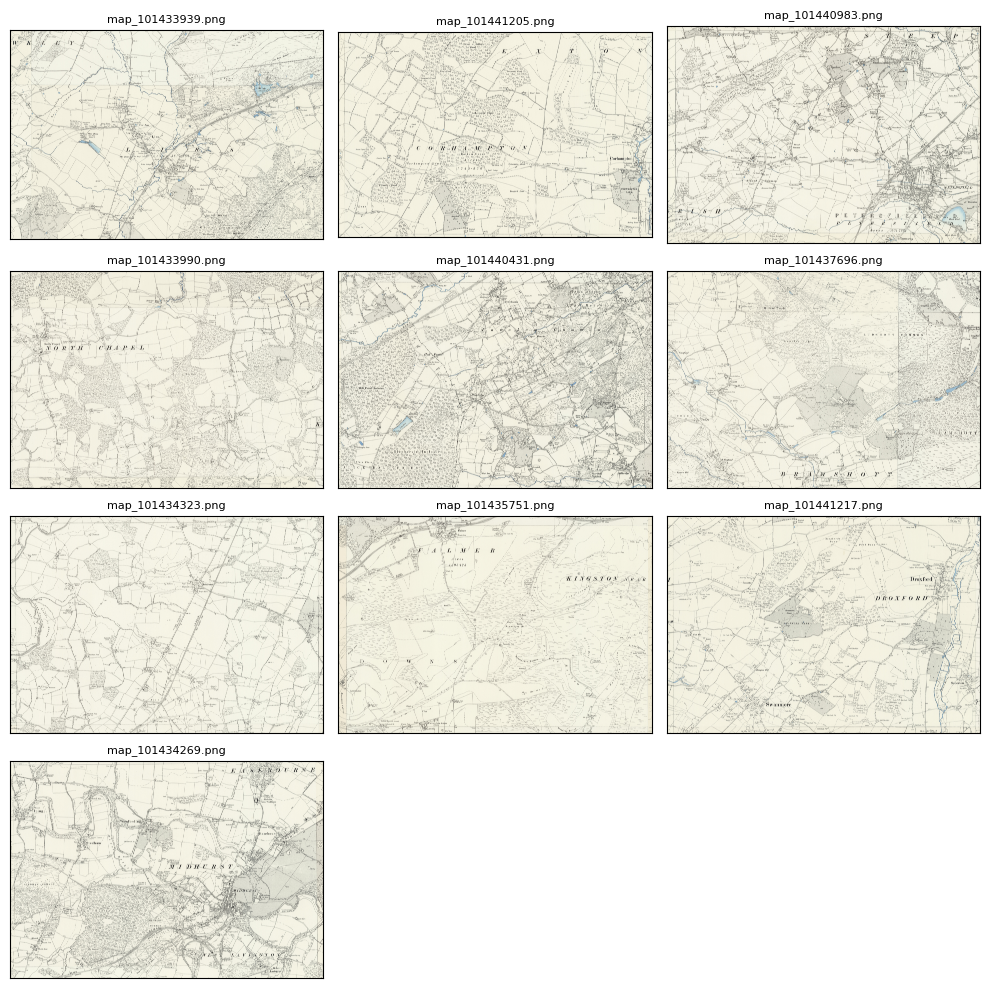

In [25]:
maps.show_sample(tree_level="parent", num_samples=10, figsize=(10, 10))

#### Save as geotiff espg 27700 to work with OS masks

In [31]:
from pyproj import Transformer

transformer = Transformer.from_crs("EPSG:4326", "EPSG:27700", always_xy=True)

for parent_id in maps.list_parents():
    coords = maps.parents[parent_id]["coordinates"]
    xmin, ymin, xmax, ymax = coords
    new_coords = transformer.transform_bounds(xmin, ymin, xmax, ymax)
    maps.parents[parent_id]["coordinates"] = new_coords
    maps.parents[parent_id]["crs"] = "EPSG:27700"

In [32]:
print(maps.parents["map_101433939.png"]["coordinates"])
print(maps.parents["map_101433939.png"]["crs"])

(475192.11939070607, 126479.01303338609, 480442.2872536591, 130013.4650072022)
EPSG:27700


In [33]:
# Save parent images as GeoTIFFs with CRS EPSG:27700
maps.save_parents_as_geotiffs(rewrite=True, verbose=True, crs="EPSG:27700")

  0%|          | 0/10 [00:00<?, ?it/s]

[INFO] Creating: /home/david/Documents/GitHub/MapReader/testing_notebooks/data/6_inch_png/map_101441205.tif.
[INFO] Creating: /home/david/Documents/GitHub/MapReader/testing_notebooks/data/6_inch_png/map_101433939.tif.
[INFO] Creating: /home/david/Documents/GitHub/MapReader/testing_notebooks/data/6_inch_png/map_101435751.tif.
[INFO] Creating: /home/david/Documents/GitHub/MapReader/testing_notebooks/data/6_inch_png/map_101441217.tif.
[INFO] Creating: /home/david/Documents/GitHub/MapReader/testing_notebooks/data/6_inch_png/map_101440983.tif.
[INFO] Creating: /home/david/Documents/GitHub/MapReader/testing_notebooks/data/6_inch_png/map_101437696.tif.
[INFO] Creating: /home/david/Documents/GitHub/MapReader/testing_notebooks/data/6_inch_png/map_101440431.tif.
[INFO] Creating: /home/david/Documents/GitHub/MapReader/testing_notebooks/data/6_inch_png/map_101434269.tif.
[INFO] Creating: /home/david/Documents/GitHub/MapReader/testing_notebooks/data/6_inch_png/map_101434323.tif.
[INFO] Creating: /h

## OS Downloader

In [7]:
class OSDataDownloader:
    def __init__(self, api_key):
        """
        Initialize the OSDataDownloader class.

        Parameters:
        - api_key: Your OS Data Hub API key.
        """
        self.api_key = api_key

    def get_tiff_metadata(self, tiff_path):
        """
        Extract metadata directly from a TIFF file.

        Parameters:
        - tiff_path: Path to the TIFF file.

        Returns:
        - metadata: Dictionary containing bounding box and CRS metadata.
        """
        import rasterio

        with rasterio.open(tiff_path) as src:
            if src.crs is None:
                raise ValueError(f"The TIFF file {tiff_path} has no CRS information.")

            # Extract bounding box and CRS
            bounds = src.bounds
            crs = src.crs.to_string()

            return {
                "bounding_box": (bounds.left, bounds.bottom, bounds.right, bounds.top),
                "crs": crs,
                "image_name": os.path.basename(tiff_path),
            }

    def transform_bounding_box(self, bbox, from_crs, to_crs="EPSG:27700"):
        """
        Transforms a bounding box from one CRS to another.

        Parameters:
        - bbox: Tuple of (xmin, ymin, xmax, ymax) in the source CRS.
        - from_crs: Source CRS.
        - to_crs: Target CRS (default is EPSG:27700).

        Returns:
        - Transformed bounding box as (xmin, ymin, xmax, ymax).
        """
        from pyproj import Transformer

        transformer = Transformer.from_crs(from_crs, to_crs, always_xy=True)
        xmin, ymin = transformer.transform(bbox[0], bbox[1])
        xmax, ymax = transformer.transform(bbox[2], bbox[3])
        return (xmin, ymin, xmax, ymax)

    def initialize_features_api(self, product_name, extent="GB", crs="EPSG:27700"):
        """
        Initialize the Ordnance Survey FeaturesAPI client for the specified product.

        Parameters:
        - product_name: The open data product to access.
        - extent: The spatial extent to use (default is "GB" for Great Britain).
        - crs: The CRS for the extent (default is "EPSG:27700").

        Returns:
        - features_api: An initialized FeaturesAPI client.
        """
        if extent == "GB":
            extent_obj = Extent.from_predefined("GB")
        else:
            xmin, ymin, xmax, ymax = extent
            polygon = Polygon(
                [(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin), (xmin, ymin)]
            )
            extent_obj = Extent(polygon, crs)

        features_api = FeaturesAPI(
            key=self.api_key, product_name=product_name, extent=extent_obj
        )
        return features_api

    def query_os_data(self, features_api, product_filter=None, type_filter=None):
        """
        Query Ordnance Survey open data using the FeaturesAPI client and filter by product name.

        Parameters:
        - features_api: An initialized FeaturesAPI client.
        - product_filter: The name of the OS open data product to filter.

        Returns:
        - gdf: GeoDataFrame with the queried data or None if no data is found.
        """
        response = features_api.query()
        if "features" not in response or not response["features"]:
            print("No data found for this bounding box.")
            return None

        gdf = gpd.GeoDataFrame.from_features(response["features"])
        if "geometry" not in gdf.columns:
            print("The API response does not include a 'geometry' column.")
            return None

        gdf = gdf.set_geometry("geometry")
        gdf.crs = "EPSG:27700"

        if product_filter:
            gdf = gdf[gdf["product"] == product_filter]
            if gdf.empty:
                print(
                    f"No data found for product '{product_filter}' within the extent."
                )
                return None

        if type_filter:
            gdf = gdf[gdf["Type"] == type_filter]
            if gdf.empty:
                print(f"No data found for Type '{type_filter}'.")
                return None

        return gdf

    def download_os_data(
        self,
        tiff_path,
        product_name,
        output_file=None,
        product_filter=None,
        type_filter=None,
    ):
        """
        Download Ordnance Survey open data for the specified TIFF and product.

        Parameters:
        - tiff_path: Path to the TIFF file.
        - product_name: The OS open data product to query.
        - output_file: Optional path to save the queried data.
        - product_filter: The name of the OS open data product to filter.
        - type_filter: Optional filter for the 'Type' column in the GeoDataFrame.

        Returns:
        - gdf: GeoDataFrame with the queried data or None if no data is found.
        """
        metadata = self.get_tiff_metadata(tiff_path)
        bbox_27700 = self.transform_bounding_box(
            metadata["bounding_box"], from_crs=metadata["crs"], to_crs="EPSG:27700"
        )

        features_api = self.initialize_features_api(
            product_name, extent=bbox_27700, crs="EPSG:27700"
        )
        gdf = self.query_os_data(features_api, product_filter, type_filter=type_filter)

        if gdf is not None and output_file:
            gdf.to_file(
                output_file,
                driver="GeoJSON"
                if output_file.endswith(".geojson")
                else "ESRI Shapefile",
            )

        return gdf

In [ ]:
# Initialize downloader

# Open Products:
# zoomstack_district_buildings, zoomstack_foreshore, zoomstack_greenspace,
# zoomstack_local_buildings, zoomstack_national_parks, zoomstack_sites,
# zoomstack_surface_water, zoomstack_urban_areas, zoomstack_woodland,
# zoomstack_boundaries, zoomstack_contours, zoomstack_ETL, zoomstack_rail,
# zoomstack_roads_local, zoomstack_roads_national, zoomstack_roads_regional,
# zoomstack_waterlines, open_USRN, zoomstack_airports, zoomstack_names,
# zoomstack_railway_stations, openUPRN_address, openTOID_highways_network,
# openTOID_sites, openTOID_topography, Zoomstack_DistrictBuildings,

# Zoomstack_Foreshore, Zoomstack_Greenspace, Zoomstack_LocalBuildings,
# Zoomstack_NationalParks, Zoomstack_Sites, Zoomstack_Surfacewater,
# Zoomstack_UrbanAreas, Zoomstack_Woodland, Zoomstack_Boundaries,
# Zoomstack_Contours, Zoomstack_ETL, Zoomstack_Rail, Z
# oomstack_RoadsLocal, Zoomstack_RoadsNational, Zoomstack_RoadsRegional,
# Zoomstack_Waterlines, OpenUSRN_USRN, Zoomstack_Airports,
# Zoomstack_Names, Zoomstack_RailwayStations,
# OpenTOID_HighwaysNetwork, OpenTOID_SitesLayer, OpenTOID_TopographyLayer

# Premium Products:
# topographic_area, topographic_point, topographic_line,
# water_network_link, water_network_node, path_network_link,
# path_network_node, highways_connecting_link, highways_connecting_node,
# highways_ferry_link, highways_ferry_node, highways_path_link,
# highways_path_node, highways_road_link, highways_road_node,
# highways_street, greenspace_area, sites_access_point,
# sites_functional_site, sites_routing_point, topographic_boundary,
# cartographic_symbol, cartographic_text, Topography_TopographicArea,
# Topography_TopographicPoint, Topography_TopographicLine,
# WaterNetwork_WatercourseLink, WaterNetwork_HydroNode, DetailedPathNetwork_RouteLink,
# DetailedPathNetwork_RouteNode, Highways_ConnectingLink, Highways_ConnectingNode,
# Highways_FerryLink, Highways_FerryNode, Highways_PathLink,
# Highways_PathNode, Highways_RoadLink, Highways_RoadNode,
# Highways_Street, Greenspace_GreenspaceArea, Sites_AccessPoint,
# Sites_FunctionalSite, Sites_RoutingPoint, Topography_BoundaryLine,
# Topography_CartographicSymbol, Topography_CartographicText

In [37]:
PRODUCTS = {
    "local_buildings": "Zoomstack_LocalBuildings",
    # "district_buildings": "Zoomstack_DistrictBuildings",
    # "local_roads": "Zoomstack_RoadsLocal"
    # "urban_areas": "Zoomstack_UrbanAreas",
    # Add any extra available products
}

# Validate product name
product_key = "local_buildings"  # Replace with user input or selection
if product_key not in PRODUCTS:
    raise ValueError(
        f"Product '{product_key}' is not recognized. Choose from: {list(PRODUCTS.keys())}"
    )

product_name = PRODUCTS[product_key]

In [17]:
# Initialize downloader
downloader = OSDataDownloader(
    api_key="oX1WR2nDOAzhICIRNQWhAhBP2mtQp8I8",
)

# Query and download data for a specific TIFF
tiff_path = "./data/6_inch_png/map_101433939.tif"
gdf = downloader.download_os_data(
    tiff_path=tiff_path,
    product_name="Zoomstack_LocalBuildings",
    # type_filter="Local",
    output_file="./built_up_areas.geojson",
)

if gdf is None:
    print("No data returned for the specified bounding box.")
else:
    print("Downloaded data:")
    print(gdf.head())

Downloaded data:
                                            geometry  \
0  MULTIPOLYGON (((476641.460 129695.100, 476641....   
1  MULTIPOLYGON (((476418.560 129704.200, 476396....   
2  MULTIPOLYGON (((476704.350 129700.890, 476702....   
3  MULTIPOLYGON (((476407.590 129801.720, 476414....   
4  MULTIPOLYGON (((476415.710 129828.840, 476417....   

                              GmlID  OBJECTID  \
0  Zoomstack_LocalBuildings.9898746   9898746   
1  Zoomstack_LocalBuildings.9898747   9898747   
2  Zoomstack_LocalBuildings.9898748   9898748   
3  Zoomstack_LocalBuildings.9898749   9898749   
4  Zoomstack_LocalBuildings.9898750   9898750   

                                   UUID  SHAPE_Length  SHAPE_Area  
0  258113e3-7a09-4af0-b40e-0e42889c5f2d     53.889654    156.7960  
1  35cb298e-8bae-419c-ad01-b0c5c44d829d     75.025346    338.6352  
2  ed5af327-7e99-4e24-92a4-8a6af482c67e     81.352583    395.9736  
3  dbefc37e-9960-46ba-9214-c38b45540467     56.967317    175.0832  
4  281840fa

In [38]:
# Automating Queries for Multiple Products

combined_gdf = gpd.GeoDataFrame()

for product_key, product_name in PRODUCTS.items():
    print(f"Querying product: {product_name}")
    try:
        gdf = downloader.download_os_data(
            tiff_path=tiff_path,
            product_name=product_name,
            output_file=None,  # Skip saving intermediate files
        )
        if gdf is not None:
            combined_gdf = pd.concat([combined_gdf, gdf], ignore_index=True)
    except Exception as e:
        print(f"Error querying product {product_name}: {e}")

if not combined_gdf.empty:
    combined_gdf.to_file("./combined_data.geojson", driver="GeoJSON")

Querying product: Zoomstack_LocalBuildings


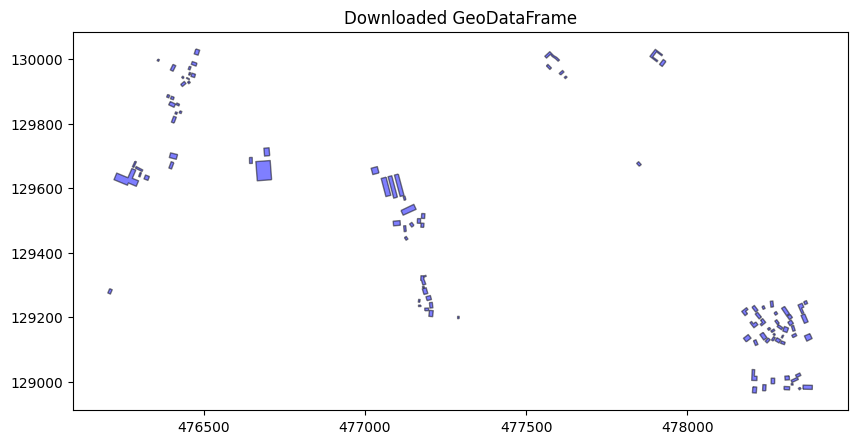

In [39]:
import matplotlib.pyplot as plt


def plot_geodataframe_fixed(gdf, color="blue", alpha=0.5):
    """
    Plot the GeoDataFrame to visualize the geometries.

    Parameters:
    - gdf: GeoDataFrame to plot.
    - color: Color of the geometries (default is "blue").
    - alpha: Transparency of the geometries (default is 0.5).

    Returns:
    - None
    """
    if gdf.crs is None:
        raise ValueError("GeoDataFrame does not have a CRS.")
    if gdf.empty:
        raise ValueError("GeoDataFrame is empty. Cannot plot.")

    # Ensure geometries are valid
    valid_geometries = gdf[gdf.geometry.notnull() & gdf.geometry.is_valid]
    if valid_geometries.empty:
        raise ValueError("GeoDataFrame contains no valid geometries after filtering.")

    # Plot the geometries
    fig, ax = plt.subplots(figsize=(10, 10))
    valid_geometries.plot(ax=ax, color=color, alpha=alpha, edgecolor="black")
    ax.set_title("Downloaded GeoDataFrame")
    plt.show()


# Call the fixed function with the downloaded data
plot_geodataframe_fixed(gdf)

In [40]:
import numpy as np  # Import numpy for isinf and isnan


def plot_geodata_on_tiff(
    tiff_path, gdf, alpha=1, overlay_color="red", zoom_to_geodata=True
):
    """
    Plot GeoDataFrame over a TIFF image with optional zooming to geodata extent.

    Parameters:
    - tiff_path: Path to the TIFF file.
    - gdf: GeoDataFrame to overlay on the TIFF image.
    - alpha: Transparency level for overlay (default is 0.5).
    - overlay_color: Color for overlay polygons (default is "red").
    - zoom_to_geodata: Whether to zoom to the GeoDataFrame extent (default is True).

    Returns:
    - None
    """
    with rasterio.open(tiff_path) as src:
        # Debugging the CRS
        print("TIFF CRS:", src.crs)
        print("GeoDataFrame CRS:", gdf.crs)

        # Reproject GeoDataFrame only if CRS differs
        if not gdf.crs.equals(src.crs):
            print(f"Reprojecting GeoDataFrame from {gdf.crs} to {src.crs}.")
            gdf = gdf.to_crs(src.crs)

        # Check validity of geometries
        gdf = gdf[gdf.geometry.notnull() & gdf.is_valid]
        if gdf.empty:
            print(
                "Filtered GeoDataFrame is empty. Check the reprojection or data validity."
            )
            return

        # Plot the TIFF
        fig, ax = plt.subplots(figsize=(10, 10))
        show(src, ax=ax, title="TIFF with GeoData Overlay")

        # Overlay the GeoDataFrame
        gdf.boundary.plot(ax=ax, color=overlay_color, linewidth=1, alpha=alpha)
        gdf.plot(ax=ax, color=overlay_color, alpha=alpha)

        # Zoom to the extent of the GeoDataFrame
        if zoom_to_geodata:
            xmin, ymin, xmax, ymax = gdf.total_bounds
            if all(
                map(
                    lambda x: x is not None and np.isfinite(x), [xmin, ymin, xmax, ymax]
                )
            ):
                ax.set_xlim(xmin, xmax)
                ax.set_ylim(ymin, ymax)
                print(f"Zoomed to GeoDataFrame bounds: {xmin}, {ymin}, {xmax}, {ymax}")
            else:
                print("Cannot zoom to GeoDataFrame bounds due to invalid extent.")

        plt.show()

TIFF CRS: EPSG:27700
GeoDataFrame CRS: EPSG:27700
Zoomed to GeoDataFrame bounds: 476201.96, 128964.22, 478388.02, 130032.03


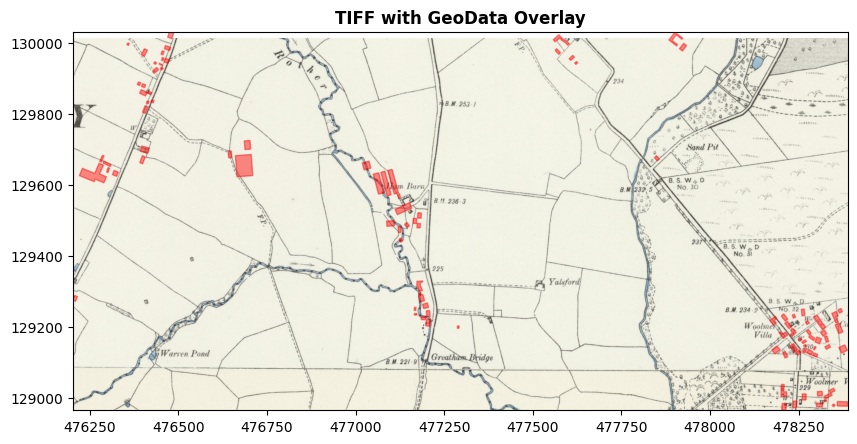

In [41]:
# Example usage
tiff_path = "./data/6_inch_png/map_101433939.tif"
plot_geodata_on_tiff(tiff_path, gdf, alpha=0.45)